Quick analysis to check new data

In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

import scipy.stats as stats
import scipy.optimize as opt
from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
run = 277 #44 #70 #64
dsp_id = '06'
user = False
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


# dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']
dsp_list = ['energy', 'trapEftp', 'trapEftp_cal', 'trapEmax', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0"]

df, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)




Warning, LH5 user directory not found: /global/cfs/cdirs/m2676/users/grsong/CAGE_LH5_USER
user: False; cal: True; hit: True
Using hit files
loading data for /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2152_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2153_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2154_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2155_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2156_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2157_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2158_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2159_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2160_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2161_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2162_hit.lh5 /global/cfs/cdirs/m2676/data/cage/LH5/hit/cage_run277_cyc2163_hit.lh5 /gl

<ipython-input-3-f23fd71b0dcc>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())


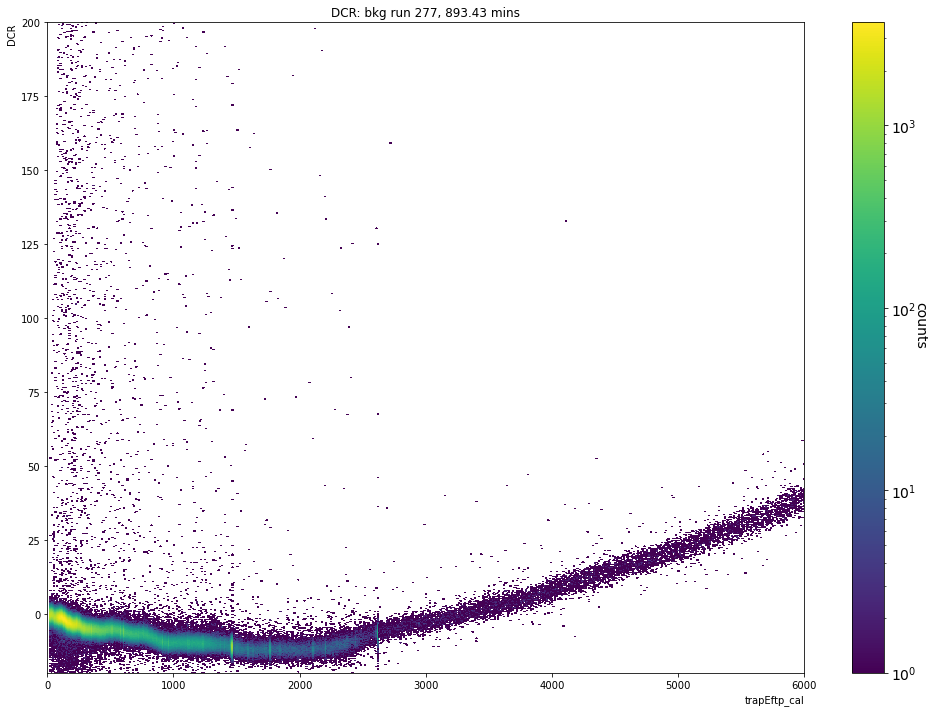

In [3]:
df_cut = df.query(f'trapEftp_cal > 20 and trapEftp_cal < 6000')
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()


In [6]:
df_corr = cage_utils.corrDCR(df_cut, 'trapEftp_cal', dcr_fit_hi=75, e_bins=nbx, elo=elo, ehi=ehi, quad=False).copy()
print(df_corr)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
#df_cut = df.query(f'trapEftp_cal > 20 and trapEftp_cal < 6000')
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_corr['trapEftp_cal'], df_corr['dcr_corr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()


In [ ]:
df_cut = df.query(f'trapEftp_cal > 20 and trapEftp_cal < 6000')
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()

In [ ]:
plt.hist2d(df['trapEftp_cal'], df['dcr'], bins=300)

In [ ]:
# select energy type

#trapEmax (uncal)
# etype = 'trapEmax'
# elo, ehi, epb = 0, 3000, 1
# blo, bhi, bpb = 0, 10000, 100

#trapEmax_cal (cal)
# etype = 'trapEmax_cal'
# elo, ehi, epb = 0, 5000, 10

# onboard energy
# etype = 'energy'
# elo, ehi, epb = 0, 1000000, 100

# # trapEftp (uncal)
# etype = 'trapEftp'
# elo, ehi, epb = 0, 10000, 10

# trapEftp_cal (cal)
etype = 'trapEftp_cal'
elo, ehi, epb = 0, 6000, 10




In [ ]:
# Baseline vs E
# %matplotlib widget

blo, bhi, bpb = 9200, 9400, 1
nbx = int((ehi-elo)/epb)
nby = int((bhi-blo)/bpb)

h = plt.hist2d(df[etype], df['bl'], bins=[nbx,nby],
                       range=[[elo, ehi], [blo, bhi]], norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl', ha='right', y=1)
plt.title('Baseline, alpha')
# plt.tight_layout()
plt.show()

In [ ]:
blo, bhi, bpb = 8800, 9800, 1
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(df['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

bl_cut_lo, bl_cut_hi = 9150,9320

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [ ]:
# Baseline vs E

bslo, bshi, bspb = -5, 10, 0.1
nbx = int((ehi-elo)/epb)
nby = int((bshi-bslo)/bspb)

h = plt.hist2d(df[etype], df['bl_slope'], bins=[nbx,nby],
                       range=[[elo, ehi], [bslo, bshi]], norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl_slope', ha='right', y=1)
plt.title('Baseline slope')
# plt.tight_layout()
plt.show()

In [ ]:
bslo, bshi, bspb = -5, 10, 0.1
nbx = int((bshi-bslo)/bspb)

bl_slope_hist, bins = np.histogram(df['bl_slope'], bins=nbx,
                range=[bslo, bshi])

plt.semilogy(bins[1:], bl_slope_hist, ds='steps', c='b', lw=1)

bl_slo_cut_lo, bl_slo_cut_hi = -4,4

plt.axvline(bl_slo_cut_lo, c='r', lw=1)
plt.axvline(bl_slo_cut_hi, c='r', lw=1)

plt.xlabel('bl_slope', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [ ]:
# Baseline vs E

bsiglo, bsighi, bsigpb = 2, 7, 0.01
nbx = int((ehi-elo)/epb)
nby = int((bsighi-bsiglo)/bsigpb)

h = plt.hist2d(df[etype], df['bl_sig'], bins=[nbx,nby],
                       range=[[elo, ehi], [bsiglo, bsighi]], norm=LogNorm())

cb = plt.colorbar(h[3], ax=plt.gca())
plt.xlabel(f'{etype}', ha='right', x=1)
plt.ylabel('bl_sig', ha='right', y=1)
plt.title('Baseline Sig, alpha')
# plt.tight_layout()
plt.show()

In [ ]:
# use baseline cut
# df_cut = df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()
df_cut = df.query(f'trapEftp_cal > 20 and trapEftp_cal < 6000')


#create dcr/E 
# df_cut['dcr_norm'] = df_cut['dcr'] / df_cut['trapEftp']

#create A/E cal 
# df_cut['AoE_cal'] = df_cut['A_10'] / df_cut['trapEftp_cal']

#creat new DCR
# const = 0.0555
# df_cut['dcr_linoff'] = df_cut['dcr_raw'] + const*df_cut['trapEmax']

# #create 10-90
# df_cut['10-90'] = df_cut['tp_90']- df_cut['tp_10']

# #create 50-90
# df_cut['50-90'] = df_cut['tp_90']- df_cut['tp_50']

#create 0-50
# df_cut['tp0_50'] = df_cut['tp_50']- df_cut['tp_0']

In [ ]:
# Make energy spectrum
fig, ax = plt.subplots()
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df['trapEftp_cal'], bins=nbx,
                range=[elo, ehi])


plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nruntime {rt_min:.2f}', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.xlabel('trapEftp_cal (keV)', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Calibrated Energy', fontsize=16)

# plt.xlim(40, 80)

# plt.setp(ax.get_xticklabels(), fontsize=14)
# plt.setp(ax.get_yticklabels(), fontsize=14)

In [ ]:
# Make energy spectrum
fig, ax = plt.subplots()
elo, ehi, epb = 40, 80, 0.25
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, ebins = np.histogram(df['trapEftp_cal'], bins=nbx,
                range=[elo, ehi])


plt.semilogy(ebins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nruntime {rt_min:.2f}', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.xlabel('trapEftp_cal (keV)', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Calibrated Energy', fontsize=16)

plt.xlim(40, 80)

In [ ]:
# Alpha A/E
alo, ahi, apb = 0.0, 0.125, 0.001
# elo, ehi, epb = 0, 10000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

h = plt.hist2d(df_cut[etype], df_cut['AoE'], bins=[nbx,nby],
                range=[[elo, ehi], [alo, ahi]], norm=LogNorm())

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('A/E', ha='right', y=1)
# plt.legend()
plt.title(f'A/E: r = {radius} mm; theta = {angle_det} deg\n{runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_a10oE_run{run}.png', dpi=200)
plt.show()

In [ ]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
plt.show()

In [ ]:
dlo, dhi, dpb = -20., 200, 0.1
nb_dcr = int((dhi-dlo)/dpb)

dcr_hist, dcr_bins = np.histogram(df_cut['dcr'], bins=nb_dcr,
                range=[dlo, dhi])

plt.semilogy(dcr_bins[1:], dcr_hist, ds='steps', c='b', lw=1)

# bl_cut_lo, bl_cut_hi = 9150,9320

# plt.axvline(20, c='r', lw=1)
# plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('dcr', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [ ]:
elo, ehi, epb = 0, 6000, 10
nbx = int((ehi-elo)/epb)

# df_dcr_fit = df_cut.query('dcr> -10 and dcr< 20').copy()
median, xedges, binnumber = stats.binned_statistic(df_cut['trapEftp_cal'], df_cut['dcr'], statistic = "median", bins = 600, range = [20,2800])

en_bin_centers = pgh.get_bin_centers(xedges)
cal_en_bin_centers = pgh.get_bin_centers(yedges)

idx = np.isfinite(en_bin_centers) & np.isfinite(median)


fit_raw = np.polyfit(en_bin_centers[idx], median[idx], deg=1)

print(fit_raw)

dcr_fit_const = fit_raw[0]
dcr_fit_offset = fit_raw[1]
# err = np.sqrt(np.diag(cov))

In [ ]:
# print(en_bin_centers)
# en_bin_centers = pgh.get_bin_centers(xedges)

In [ ]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
plt.plot(en_bin_centers, median, 'r', label='fit')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
# plt.show()

In [ ]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 200, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
plt.plot(en_bin_centers, y, 'r', label='fit')


plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
# plt.show()

In [ ]:
# const, offset, err = cage_utils.corrDCR(df_cut, etype='trapEftp', e_bins=300, elo=0, ehi=6000, dcr_fit_lo=-30, dcr_fit_hi=200)
df_cut['dcr_plot'] = df_cut['dcr']-dcr_fit_offset + ((-1*dcr_fit_const))*df_cut['trapEftp_cal']

In [ ]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = -20., 75, 0.1 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_plot'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')


plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
# plt.show()

In [ ]:
df_cut['DCRoE'] = df_cut['dcr']/df_cut['trapEftp_cal']

In [ ]:
# DCR vs E
# etype = 'trapEmax'
# elo, ehi, epb = 500, 1500, 10
elo, ehi, epb = 0, 6000, 10
# elo, ehi, epb = 0, 20000, 10
# dlo, dhi, dpb = -0.08, 0.025, 0.0005
# dlo, dhi, dpb = -10., 30, 0.1
dlo, dhi, dpb = 0.02,0.05, 0.0001 #dsp_id= 02
nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)


alpha_dcr_hist, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['DCRoE'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))
X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

pcm = plt.pcolormesh(X, Y, alpha_dcr_hist, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("counts", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=14)

# y = (dcr_fit_const*en_bin_centers + dcr_fit_offset)
# plt.plot(en_bin_centers, y, 'r', label='fit')


plt.xlabel(etype, ha='right', x=1)
plt.ylabel('DCR/trapEftp_cal', ha='right', y=1)
plt.title(f'DCR: {runtype} run {run}, {rt_min:.2f} mins')
plt.tight_layout()
# plt.savefig(f'./plots/normScan/{runtype}_dcr_norm_run{run}.png', dpi=200)
# plt.show()